# Lecture 7 - Decision Trees and Random Forests

```{contents}
:local:
:depth: 1
```

## Learning goals

- Explain the intuition of **decision trees** for regression and classification.
- Read **Gini** and **entropy** for splits and **MSE** for regression splits.
- Grow a tree step by step and inspect internal structures: nodes, depth, leaf counts.
- Control tree growth with `max_depth`, `min_samples_leaf`, `min_samples_split`.
- Visualize a fitted tree and feature importance.
- Train a **Random Forest** and compare to a single tree.
- Use **out of bag (OOB)** score for quick validation.
- Put it all together in a short end-to-end workflow.

  [![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1Mkzv1qh9t9tL9w6m4C2U1Qw3W2c2W8bR?usp=sharing)

---

## 0. Setup

In [1]:
# 0. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
except Exception:
    Chem = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="X has feature names")

## 1. Decision tree

### 1.1 Load data and build descriptors

We will reuse the same dataset to keep the context consistent. If RDKit is available, we compute four descriptors; otherwise we fallback to numeric columns that are already present.

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
df_raw.head()

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10"
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10"
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2"
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6"


In [3]:
def calc_descriptors(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc = df_raw["SMILES"].apply(calc_descriptors)
df = pd.concat([df_raw, desc], axis=1)
df.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0


```{admonition} Features
We will use `MolWt`, `LogP`, `TPSA`, `NumRings` as base features. They worked well in earlier lectures and are fast to compute.
```

---
### 1.2 What is a decision tree


A tree splits the feature space into rectangles by asking simple questions like `LogP <= 1.3`. Each split tries to make the target inside each branch more pure.

- For **classification**, purity is measured by **Gini** or **entropy**.
- For **regression**, it is common to use **MSE** reduction.

```{admonition} Purity
- Gini for a node with class probs \(p_k\): \(1 - \sum_k p_k^2\)
- Entropy: \(-\sum_k p_k \log_2 p_k\)
- Regression impurity at a node: mean squared error to the node mean
```




```{admonition} Idea
A decision tree learns a sequence of questions like `MolWt <= 200.5`. Each split aims to make child nodes purer.
```

- **Regression tree** chooses splits that reduce **MSE** the most. A leaf predicts the **mean** of training `y` within that leaf.
- **Classification tree** chooses splits that reduce **Gini** or **entropy**. A leaf predicts the **majority class** and class probabilities.

Key hyperparameters you will tune frequently:
- `max_depth` - maximum levels of splits
- `min_samples_split` - minimum samples required to attempt a split
- `min_samples_leaf` - minimum samples allowed in a leaf
- `max_features` - number of features to consider when finding the best split

Trees handle different feature scales naturally, and they do not require standardization. They can struggle with high noise and very small datasets if left unconstrained.

```{admonition} Vocabulary
- **Node** is a point where a question is asked.  
- **Leaf** holds a simple prediction.  
- **Impurity** is a measure of how mixed a node is. Lower is better.
 > For regression, impurity at a node is measured by mean squared error to the node mean.
 > For classification, it is measured by **Gini** for a node with class probs $p_k$: $(1 - \sum_k p_k^2$ or **Entropy**: $-\sum_k p_k \log_2 p_k\$

```
---

### 1.3 Tiny classification example: one split

We start with toxicity as a binary label to see a single split and the data shape at each step.

We will split the dataset into train and test parts. Stratification (`stratify = y`) keeps the class ratio similar in both parts, which is important when classes are imbalanced.

In [4]:
df_clf = df[["MolWt", "LogP", "TPSA", "NumRings", "Toxicity"]].dropna()
label_map = {"toxic": 1, "non_toxic": 0}
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int)
X = df_clf[["MolWt", "LogP", "TPSA", "NumRings"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape

(460, 4)

As you remember, we have total 575 data points and 80% goes to training samples.

You can glance at the first few rows to get a feel for the feature scales. Trees do not require scaling, but it is still useful context.

In [5]:
X_train.head()

,MolWt,LogP,TPSA,NumRings
275,309.162,4.8137,17.07,4.0
411,126.203,1.9771,24.72,0.0
328,195.221,2.8936,32.59,3.0
444,272.282,-0.8694,109.93,2.0
6,99.133,0.2386,20.31,1.0


We will grow a stump: a tree with `max_depth=1`. This forces one split. It helps you see how a split is chosen and how samples are divided.

```{admonition} Stump

The tree considers possible thresholds on each feature.
For each candidate threshold it computes an impurity score on the left and right child nodes. We use Gini impurity, which gets smaller when a node contains mostly one class.
It picks the feature and threshold that bring the largest impurity decrease.
```

In [6]:
stump = DecisionTreeClassifier(max_depth=1, criterion="gini", random_state=0)
stump.fit(X_train, y_train)

print("Feature used at root:", stump.tree_.feature[0])
print("Threshold at root:", stump.tree_.threshold[0])
print("n_nodes:", stump.tree_.node_count)
print("children_left:", stump.tree_.children_left[:3])
print("children_right:", stump.tree_.children_right[:3])

Feature used at root: 0
Threshold at root: 134.1999969482422
n_nodes: 3
children_left: [ 1 -1 -1]
children_right: [ 2 -1 -1]


The model stores feature indices internally. Mapping that index back to the column name makes the split human readable.

In [7]:
# Map index to name for readability
feat_names = X_train.columns.tolist()
root_feat = feat_names[stump.tree_.feature[0]]
thr = stump.tree_.threshold[0]
print(f"Root rule: {root_feat} <= {thr:.3f}?")

Root rule: MolWt <= 134.200?


Read the rule as: if the condition is true, the sample goes to the left leaf, otherwise to the right leaf.


```{admonition} How good is one split
A single split is intentionally simple. It may already capture a strong signal if one feature provides a clean separation. We will check test performance with standard metrics.
> Precision of class k: among items predicted as k, how many were truly k
> Recall of class k: among true items of k, how many did we catch
> F1 is the harmonic mean of precision and recall
> Support is the number of true samples for each class
It picks the feature and threshold that bring the largest impurity decrease.
```

In [8]:
# Evaluate stump
from sklearn.metrics import classification_report
y_pred = stump.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
cm

              precision    recall  f1-score   support

           0      0.824     0.700     0.757        20
           1      0.939     0.968     0.953        95

    accuracy                          0.922       115
   macro avg      0.881     0.834     0.855       115
weighted avg      0.919     0.922     0.919       115



array([[14,  6],
       [ 3, 92]], dtype=int64)

Use the confusion matrix to see the error pattern.

In this case:
`FP` are non toxic predicted as toxic
`FN` are toxic predicted as non toxic

Which side is larger tells you which type of mistake the one split is making more often.

Now, let's visualize the rule.
The tree plot below shows the root node with its split, the Gini impurity at each node, the sample counts, and the class distribution. Filled colors hint at the majority class in each leaf.

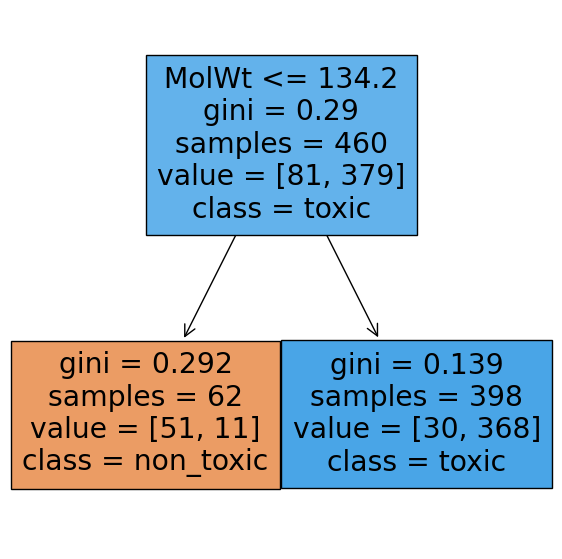

In [9]:
# Visualize stump
plt.figure(figsize=(7,7))
plot_tree(stump, feature_names=feat_names, class_names=["non_toxic","toxic"], filled=True, impurity=True)
plt.show()

---

### 1.4 Grow deeper and control overfitting

Trees can fit noise if we let them grow without limits. We control growth using a few simple knobs.

- `max_depth`: limit the number of levels
- `min_samples_split`: a node needs at least this many samples to split
- `min_samples_leaf`: each leaf must have at least this many samples

In [10]:
def fit_eval_tree(max_depth=None, min_leaf=1):
    clf = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_leaf, random_state=0
    )
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    return clf, acc

depths = [1, 2, 3, 4, 5, None]  # None means grow until pure or exhausted
scores = []
for d in depths:
    _, acc = fit_eval_tree(max_depth=d, min_leaf=3)
    scores.append(acc)

pd.DataFrame({"max_depth": [str(d) for d in depths], "Accuracy": np.round(scores,3)})

,max_depth,Accuracy
0,1,0.922
1,2,0.957
2,3,0.948
3,4,0.948
4,5,0.948
5,None,0.930


Here, we hold `min_samples_leaf = 3` and vary `max_depth`. This shows the classic underfit to overfit trend.

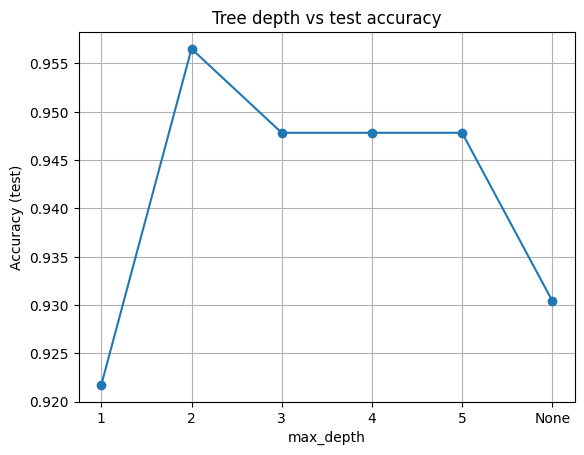

In [11]:
plt.plot([str(d) for d in depths], scores, marker="o")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (test)")
plt.title("Tree depth vs test accuracy")
plt.grid(True)
plt.show()

```{admonition} Takeaway
Shallow trees underfit. Very deep trees often overfit. Start small, add depth only if validation improves.
```

Now, let's try sweep leaf size at several depths.

We will try a small grid. This lets you see **both** knobs together.

In [12]:
def fit_acc_leaves(max_depth=None, min_leaf=1):
    clf = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_leaf, random_state=0
    )
    clf.fit(X_train, y_train)
    acc_test = accuracy_score(y_test, clf.predict(X_test))
    n_leaves = clf.get_n_leaves()  # simple and reliable
    return acc_test, n_leaves

leaf_sizes = [1, 3, 5, 10, 20]
depths = [1, 2, 3, 4, 5, None]

rows = []
for leaf in leaf_sizes:
    for d in depths:
        acc, leaves = fit_acc_leaves(max_depth=d, min_leaf=leaf)
        rows.append({
            "min_samples_leaf": leaf,
            "max_depth": str(d),
            "acc_test": acc,
            "n_leaves": leaves
        })

df_grid = pd.DataFrame(rows).sort_values(
    ["min_samples_leaf","max_depth"]
).reset_index(drop=True)
df_grid

,min_samples_leaf,max_depth,acc_test,n_leaves
0,1,1,0.921739,2
1,1,2,0.956522,4
2,1,3,0.947826,8
3,1,4,0.947826,13
4,1,5,0.947826,18
5,1,None,0.921739,34
6,3,1,0.921739,2
7,3,2,0.956522,4
8,3,3,0.947826,8
9,3,4,0.947826,12


Now, we plot test accuracy vs depth for each leaf size.

Higher min_samples_leaf tends to smooth the curves and reduce the train minus test gap.

```{admonition} Hyperparamter
Higher `min_samples_leaf` tends to smooth the curves and reduce the train minus test gap.
```

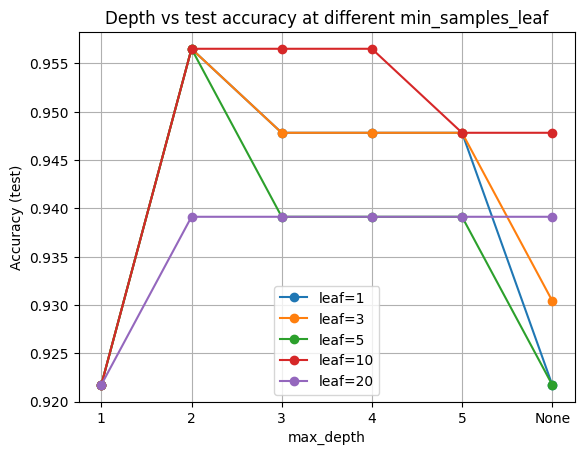

In [13]:
plt.figure()
for leaf in leaf_sizes:
    sub = df_grid[df_grid["min_samples_leaf"]==leaf]
    plt.plot(sub["max_depth"], sub["acc_test"], marker="o", label=f"leaf={leaf}")
plt.xlabel("max_depth")
plt.ylabel("Accuracy (test)")
plt.title("Depth vs test accuracy at different min_samples_leaf")
plt.grid(True)
plt.legend()
plt.show()


Finally, let's look at what happen if we fix depth and vary leaf size:

Pick a moderate depth (`4`), then look at how leaf size alone affects accuracy and model size.

In [14]:
fixed_depth = 4
rows = []
for leaf in leaf_sizes:
    clf = DecisionTreeClassifier(
        max_depth=fixed_depth, min_samples_leaf=leaf, random_state=0
    ).fit(X_train, y_train)

    rows.append({
        "min_samples_leaf": leaf,
        "acc_train": accuracy_score(y_train, clf.predict(X_train)),
        "acc_test":  accuracy_score(y_test,  clf.predict(X_test)),
        "n_nodes":   clf.tree_.node_count,
        "n_leaves":  clf.get_n_leaves(),
    })

df_leaf = pd.DataFrame(rows).sort_values("min_samples_leaf").reset_index(drop=True)
df_leaf[["min_samples_leaf","acc_train","acc_test","n_nodes","n_leaves"]]


,min_samples_leaf,acc_train,acc_test,n_nodes,n_leaves
0,1,0.950000,0.947826,25,13
1,3,0.945652,0.947826,23,12
2,5,0.945652,0.939130,23,12
3,10,0.934783,0.956522,17,9
4,20,0.923913,0.939130,15,8


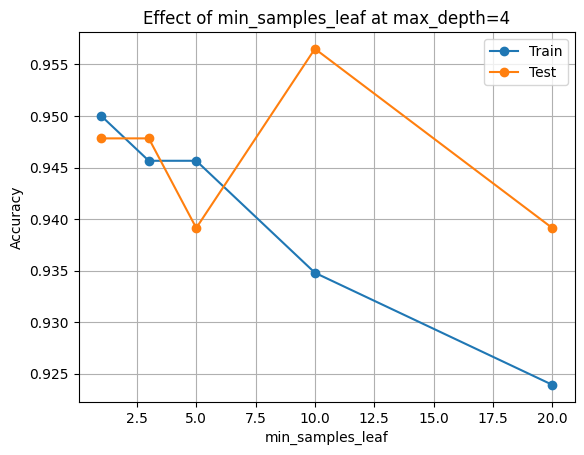

In [15]:
plt.figure()
plt.plot(df_leaf["min_samples_leaf"], df_leaf["acc_train"], marker="o", label="Train")
plt.plot(df_leaf["min_samples_leaf"], df_leaf["acc_test"],  marker="o", label="Test")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title(f"Effect of min_samples_leaf at max_depth={fixed_depth}")
plt.grid(True)
plt.legend()
plt.show()


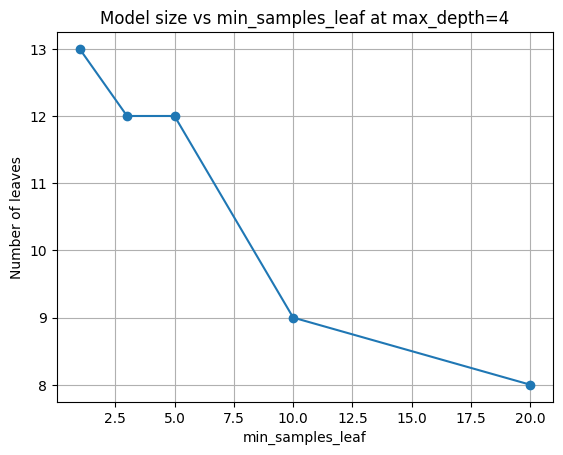

In [16]:
plt.figure()
plt.plot(df_leaf["min_samples_leaf"], df_leaf["n_leaves"], marker="o")
plt.xlabel("min_samples_leaf")
plt.ylabel("Number of leaves")
plt.title(f"Model size vs min_samples_leaf at max_depth={fixed_depth}")
plt.grid(True)
plt.show()

```{admonition} Underfitting vs. Overfitting
Higher `min_samples_leaf` tends to smooth the curves and reduce the train minus test gap.


- **Underfitting**  
  Happens when the model is too simple to capture meaningful patterns.  
  Signs:
  - Both training and test accuracy are low.
  - The decision boundary looks crude.
  - Increasing model capacity (like depth) improves results.

- **Overfitting**  
  Happens when the model is too complex and memorizes noise in the training set.  
  Signs:
  - Training accuracy is very high (often near 100%).
  - Test accuracy lags behind.
  - Model has many small leaves with very few samples.
  - Predictions fluctuate wildly for minor changes in input.

The goal is **good generalization**: high performance on unseen data, not just on the training set.

```

---

### 1.5 Model-based importance: Gini importance  

As we learned in lecture 6, ML models not only make predictions but also provide insight into which features were most useful. 

There are two main ways we can measure this: **Gini importance** (model-based) and **permutation importance** (data-based). Both give us different perspectives on feature relevance.


When fitting a tree, each split reduces impurity (measured by Gini or entropy). A feature’s importance is computed as:

- The total decrease in impurity that results from splits on that feature
- Normalized so that all features sum to `1`

This is fast and built-in, but it reflects **how the model used the features** during training. It may overstate the importance of high-cardinality or correlated features.

In [17]:
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=0).fit(X_train, y_train)

imp = pd.Series(tree_clf.feature_importances_, index=feat_names).sort_values(ascending=False)
imp

MolWt       0.601322
LogP        0.291825
TPSA        0.085734
NumRings    0.021119
dtype: float64

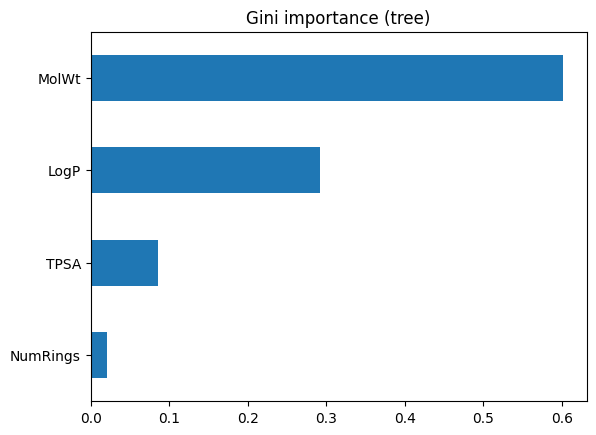

In [18]:
imp.plot(kind="barh")
plt.title("Gini importance (tree)")
plt.gca().invert_yaxis()
plt.show()


This bar chart above ranks features by how much they reduced impurity in the training process. The top feature is the one the tree found most useful for splitting. However, keep in mind this is internal to the model and may not reflect true predictive power on unseen data.



---

### 1.6 Data-based importance: Permutation importance
Permutation importance takes a different approach. Instead of looking inside the model, it asks: What happens if I scramble a feature’s values on the test set? If accuracy drops, that feature was important. If accuracy stays the same, the model did not really depend on it.

Steps:

> 1. Shuffle one feature column at a time in the test set.
> 2. Measure the drop in accuracy.
> 3. Repeat many times and average to reduce randomness.

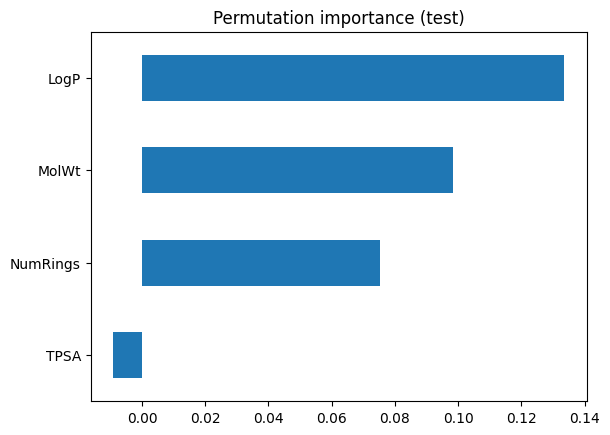

In [19]:
perm = permutation_importance(
    tree_clf, X_test, y_test, scoring="accuracy", n_repeats=20, random_state=0
)
perm_ser = pd.Series(perm.importances_mean, index=feat_names).sort_values()
perm_ser.plot(kind="barh")
plt.title("Permutation importance (test)")
plt.show()


Here, the bars show how much accuracy falls when each feature is disrupted. This provides a more honest reflection of **predictive value on unseen data**. Features that looked strong in Gini importance may shrink here if they were just splitting on quirks of the training set.


```{admonition} Comparing the two methods
Gini importance (tree-based):
> Easy to compute.
> Biased toward features with many possible split points.
> Reflects training behavior, not necessarily generalization.



Permutation importance (test-based):
> More computationally expensive (requires multiple shuffles).
> Directly tied to model performance on new data.
> Can reveal when the model “thought” a feature was important but it doesn’t hold up in practice.
```


---

## 2. Regression trees on Melting Point

So far we used trees for **classification**. Now we switch to a **regression target**: the **melting point** of molecules. The mechanics are similar, but instead of predicting a discrete class, the tree predicts a continuous value.

In [20]:
df_reg = df[["MolWt", "LogP", "TPSA", "NumRings", "Melting Point"]].dropna()
Xr = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]]
yr = df_reg["Melting Point"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

Xr_train.head(2), yr_train.head(3)

(       MolWt    LogP  TPSA  NumRings
 68   226.703  3.6870  26.3       1.0
 231  282.295  2.5255  52.6       3.0,
 68     152.1
 231    169.4
 63     247.3
 Name: Melting Point, dtype: float64)

Just like before, we can grow a stump (·max_depth=1·) to see a single split.
Instead of class impurity, the split criterion is reduction in variance of the target.

In [21]:
reg_stump = DecisionTreeRegressor(max_depth=1, random_state=0)
reg_stump.fit(Xr_train, yr_train)
print("Root feature:", Xr_train.columns[reg_stump.tree_.feature[0]])
print("Root threshold:", reg_stump.tree_.threshold[0])

Root feature: MolWt
Root threshold: 245.61299896240234


```{admonition} What can we learn from Root Feature output?
This tells us the first cut is on `MolW`. Samples with weight below ~246 g/mol are grouped separately from heavier ones.

```

Let’s vary max_depth and track R² on the test set.
Remember: 
> R² = 1 means perfect prediction,
> R² = 0 means the model is no better than the mean.


Below, we pick `depth = 4`, `leaf size = 5`. This is a good trade-off.

In [22]:
# Evaluate shallow vs deeper
depths = [1, 2, 3, 4, 6, 8, None]
r2s = []
for d in depths:
    reg = DecisionTreeRegressor(max_depth=d, min_samples_leaf=5, random_state=0).fit(Xr_train, yr_train)
    yhat = reg.predict(Xr_test)
    r2s.append(r2_score(yr_test, yhat))

pd.DataFrame({"max_depth": [str(d) for d in depths], "R2_test": np.round(r2s,3)})

,max_depth,R2_test
0,1,0.398
1,2,0.659
2,3,0.810
3,4,0.809
4,6,0.777
5,8,0.765
6,None,0.761


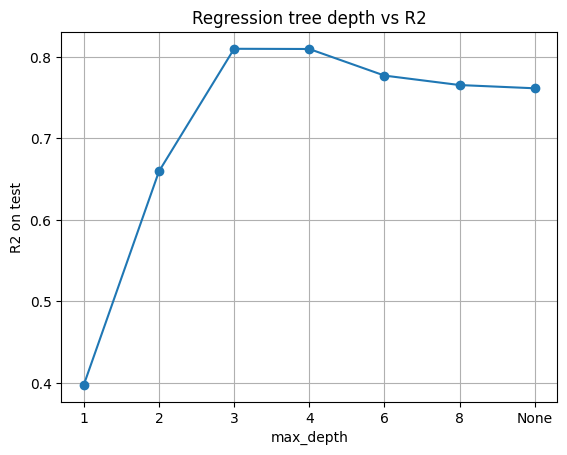

In [23]:
plt.plot([str(d) for d in depths], r2s, marker="o")
plt.xlabel("max_depth")
plt.ylabel("R2 on test")
plt.title("Regression tree depth vs R2")
plt.grid(True)
plt.show()

This mirrors the classification case: shallow trees underfit, very deep trees overfit.




Points close to the dashed line = good predictions. Scatter away from the line = errors. Here, predictions track well but show some spread at high melting points.

MSE=566.914
MAE=17.818
R2=0.809


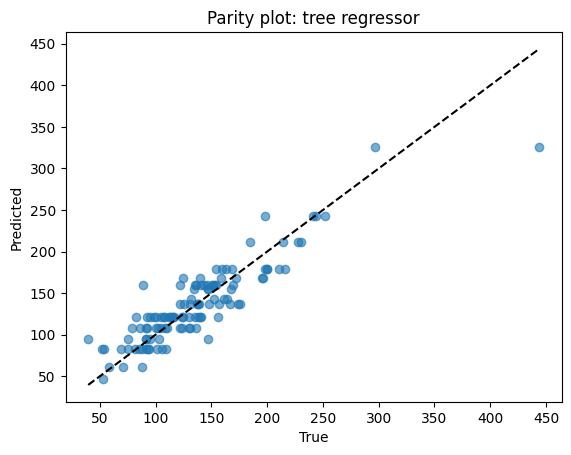

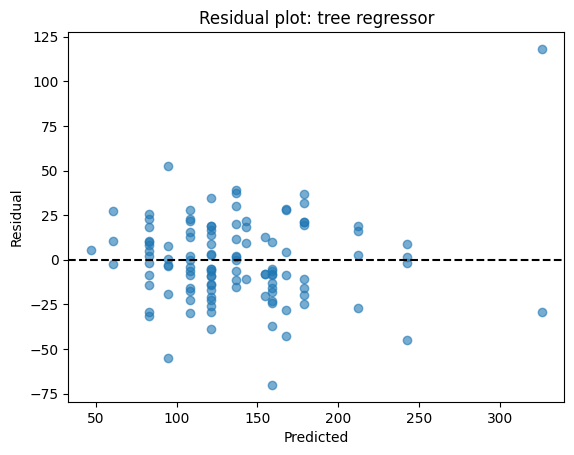

In [24]:
# Diagnostics for a chosen depth
reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=0).fit(Xr_train, yr_train)
yhat = reg.predict(Xr_test)

print(f"MSE={mean_squared_error(yr_test, yhat):.3f}")
print(f"MAE={mean_absolute_error(yr_test, yhat):.3f}")
print(f"R2={r2_score(yr_test, yhat):.3f}")

# Parity
plt.scatter(yr_test, yhat, alpha=0.6)
lims = [min(yr_test.min(), yhat.min()), max(yr_test.max(), yhat.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Parity plot: tree regressor")
plt.show()

# Residuals
res = yr_test - yhat
plt.scatter(yhat, res, alpha=0.6)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual plot: tree regressor")
plt.show()

Similar to the example we see on the linear regression, residuals (true – predicted) should scatter around zero. If you see patterns (e.g., always underpredicting high values), the model may be biased. Here, residuals are fairly centered but not perfectly homoscedastic.

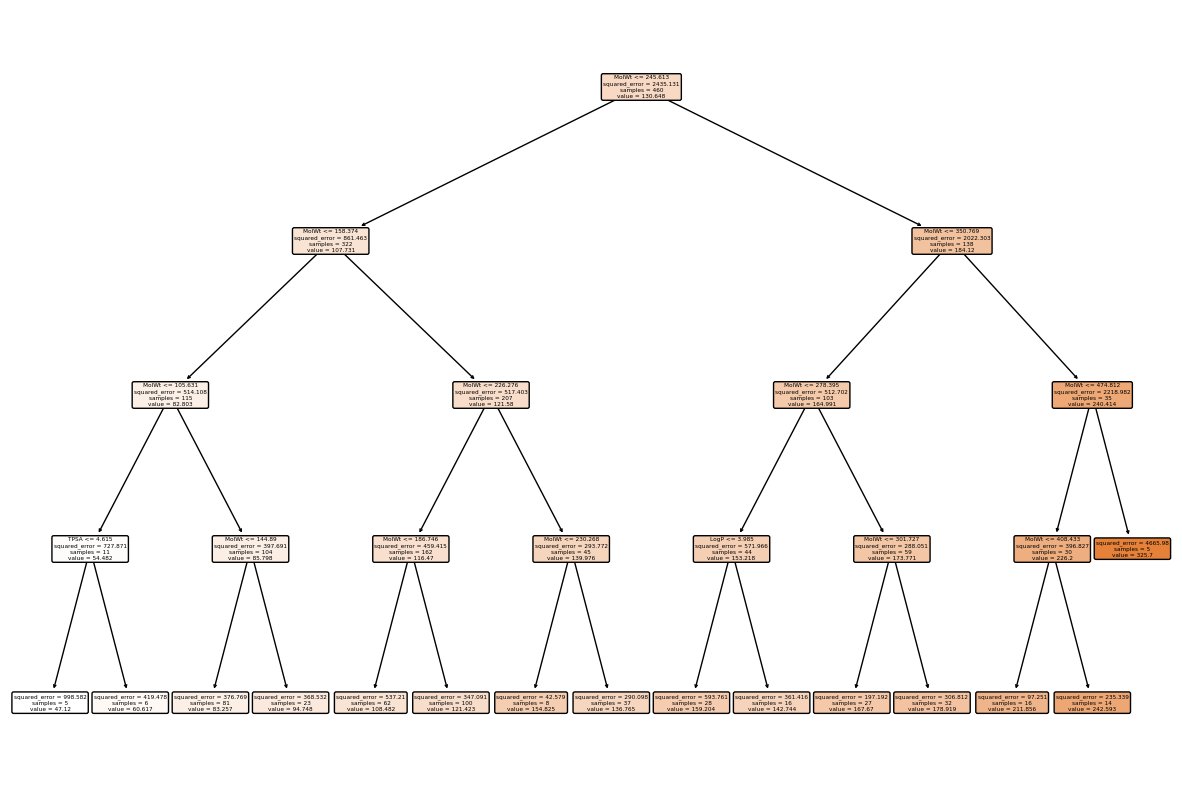

In [25]:
# Visualize a small regression tree
plt.figure(figsize=(15,10))
plot_tree(reg, feature_names=Xr_train.columns, filled=True, impurity=True, rounded=True, proportion=False)
plt.show()

```{admonition} Regression tree vs classifier tree
A regression tree is structured the same as a classifier tree, but each leaf stores an *average target value* instead of a class distribution.

```
---

## 3. Random Forest: bagging many trees



Decision trees are intuitive but unstable: a small change in data can produce a very different tree. To make trees more reliable and accurate, we use **ensembles** — groups of models working together. The most widely used ensemble of trees is the **Random Forest**.

Eseentially, a random forest grows **many decision trees**, each trained on a slightly different view of the data, and then combines their predictions:

- **Bootstrap sampling (bagging)**:  
  Each tree sees a different random subset of the training rows, sampled *with replacement*. About one-third of rows are left out for that tree (these are the **out-of-bag samples**).
  
- **Feature subsampling**:  
  At each split, the tree does not see all features — only a random subset, controlled by `max_features`. This prevents trees from always picking the same strong predictor and encourages diversity.

Each tree may be a weak learner, but when you **average many diverse trees**, the variance cancels out. This makes forests much more stable and accurate than single trees, especially on noisy data.

---

Here are some helpful aspect of forests:

- **Single deep tree** → low bias, high variance (overfit easily).  
- **Forest of many deep trees** → still low bias, but variance shrinks when you average.  
- **Built-in validation**: out-of-bag samples allow you to estimate performance without needing a separate validation set.  

In practice, random forests are a strong default: robust, interpretable at the feature level, and requiring little parameter tuning.

### 3.1 Classification forest on toxicity
We now build a forest to classify molecules as toxic vs non-toxic.  
We set:
- `n_estimators=300`: number of trees.  
- `max_features="sqrt"`: common heuristic for classification.  
- `min_samples_leaf=3`: prevent leaves with only 1 or 2 samples.

In [26]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=3,
    max_features="sqrt",
    random_state=0,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

print("OOB score:", rf_clf.oob_score_)
acc = accuracy_score(y_test, rf_clf.predict(X_test))
print("Test accuracy:", acc)

AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'

Here, **Out-of-Bag (OOB) Score** gives an internal validation accuracy, while **test accuracy** confirms performance on held-out data.


```{admonition} How the OOB score is calculated
1. For each training point, collect predictions only from the trees that did **not** see that point during training (its out-of-bag trees).
2. Aggregate those predictions (majority vote for classification, mean for regression).
3. Compare aggregated predictions against the true labels.
4. The accuracy (or R² for regression) across all training samples is the **OOB score**.
```

Forests average over many trees, so feature importance is more reliable than from a single tree. We can view both Gini importance and permutation importance.

In [ ]:
imp_rf = pd.Series(rf_clf.feature_importances_, index=feat_names).sort_values()
imp_rf.plot(kind="barh")
plt.title("Random Forest Gini importance")
plt.show()

perm_rf = permutation_importance(rf_clf, X_test, y_test, scoring="accuracy", n_repeats=20, random_state=0)
pd.Series(perm_rf.importances_mean, index=feat_names).sort_values().plot(kind="barh")
plt.title("Random Forest permutation importance (test)")
plt.show()

### 3.2 Regression forest on Melting Point
Next we apply the same idea for regression. The forest predicts a continuous value (melting point) by averaging predictions from many regression trees.

In [ ]:
rf_reg = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=3,
    max_features="sqrt",
    oob_score=True,
    random_state=0,
    n_jobs=-1
)
rf_reg.fit(Xr_train, yr_train)

print("OOB R2:", rf_reg.oob_score_)
yhat_rf = rf_reg.predict(Xr_test)
print(f"Test R2: {r2_score(yr_test, yhat_rf):.3f}")
print(f"Test MAE: {mean_absolute_error(yr_test, yhat_rf):.3f}")

Parity and feature importance plots help check performance.

In [ ]:
# Parity plot
plt.scatter(yr_test, yhat_rf, alpha=0.6)
lims = [min(yr_test.min(), yhat_rf.min()), max(yr_test.max(), yhat_rf.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Parity plot: Random Forest regressor")
plt.show()

# Feature importance
pd.Series(rf_reg.feature_importances_, index=Xr_train.columns).sort_values().plot(kind="barh")
plt.title("Random Forest importance (regression)")
plt.show()

---

## 4. Compare single tree vs forest

We look at stability across several random splits. This loop keeps code short but shows the lists of scores so students can inspect them.

In [ ]:
splits = [1, 7, 21, 42, 77]
rows = []
for seed in splits:
    X_tr, X_te, y_tr, y_te = train_test_split(Xr, yr, test_size=0.2, random_state=seed)
    t = DecisionTreeRegressor(max_depth=None, min_samples_leaf=3, random_state=seed).fit(X_tr, y_tr)
    f = RandomForestRegressor(n_estimators=300, min_samples_leaf=3, random_state=seed, n_jobs=-1).fit(X_tr, y_tr)
    r2_t = r2_score(y_te, t.predict(X_te))
    r2_f = r2_score(y_te, f.predict(X_te))
    rows.append({"seed": seed, "Tree_R2": r2_t, "Forest_R2": r2_f})

pd.DataFrame(rows).round(3)

In [ ]:
df_cmp = pd.DataFrame(rows)
plt.plot(df_cmp["seed"], df_cmp["Tree_R2"], "o-", label="Tree")
plt.plot(df_cmp["seed"], df_cmp["Forest_R2"], "o-", label="Forest")
plt.xlabel("random_state")
plt.ylabel("R2 on test")
plt.title("Stability across splits")
plt.legend()
plt.grid(True)
plt.show()

```{admonition} Observation
Forests tend to give higher and more stable test performance than a single deep tree.
```

---

## 7. End-to-end recipe

Short workflow for toxicity with a forest.

In [ ]:
# 1) Data
X = df_clf[["MolWt", "LogP", "TPSA", "NumRings"]]
y = df_clf["Toxicity"].str.lower().map(label_map).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y
)

# 2) Model
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, max_features="sqrt",
    min_samples_leaf=3, oob_score=True, random_state=15, n_jobs=-1
).fit(X_train, y_train)

# 3) Evaluate
y_hat = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]
print(f"OOB score: {rf.oob_score_:.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_hat):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")

In [ ]:
# Confusion matrix and ROC
cm = confusion_matrix(y_test, y_hat)
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve")
plt.show()

---

## 8. Quick reference

```{admonition} Common options
- DecisionTreeClassifier/Regressor: `max_depth`, `min_samples_leaf`, `min_samples_split`, `criterion`, `random_state`
- RandomForestClassifier/Regressor: add `n_estimators`, `max_features`, `oob_score`, `n_jobs`
- Use `feature_importances_` for built-in importance and `permutation_importance` for model-agnostic view
```
```{admonition} When to use
- Tree: simple rules, quick to interpret on small depth
- Forest: stronger accuracy, more stable, less sensitive to a single split
```

---

## 9. In-class activities

### 9.1 Tree vs Forest on log-solubility

- Create `y_log = log10(Solubility_mol_per_L + 1e-6)`
- Use features `[MolWt, LogP, TPSA, NumRings]`
- Train a `DecisionTreeRegressor(max_depth=4, min_samples_leaf=5)` and a `RandomForestRegressor(n_estimators=300, min_samples_leaf=5)`
- Report test **R2** for both and draw both parity plots

```python
# TO DO
```

### 9.2 Pruning with `min_samples_leaf`

- Fix `max_depth=None` for `DecisionTreeClassifier` on toxicity
- Sweep `min_samples_leaf` in `[1, 2, 3, 5, 8, 12, 20]`
- Plot test **accuracy** vs `min_samples_leaf`

```python
# TO DO
```

### 9.3 OOB sanity check

- Train `RandomForestClassifier` with `oob_score=True` on toxicity
- Compare OOB score to test accuracy over seeds `[0, 7, 21, 42]`

```python
# TO DO
```

### 9.4 Feature importance agreement

- On melting point, compute forest `feature_importances_` and `permutation_importance`
- Plot both and comment where they agree or disagree

```python
# TO DO
```

### 9.5 Small tree visualization

- Fit a `DecisionTreeClassifier(max_depth=2)` on toxicity
- Use `plot_tree` to draw it and write down the two split rules in plain language

```python
# TO DO
```

---